# loading library

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')


# loading data

In [5]:
data =pd.read_csv('data.csv')
data = data.drop_duplicates()
data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


# clustering data
* dbscan 

* k means


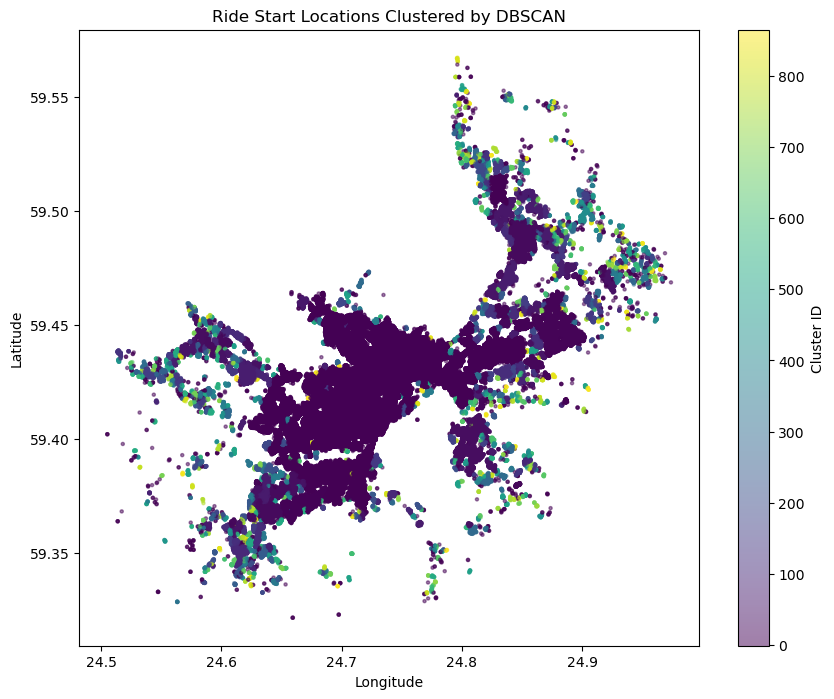

In [14]:
# Since HDBSCAN installation is facing issues, let's proceed with DBSCAN, which is included in scikit-learn and does not require additional installation steps on Google Colab.

from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and already loaded into your Colab environment
# Prepare your data
X = data[['start_lat', 'start_lng']] 
# Use DBSCAN for clustering
# Adjust eps (radius of neighborhood) and min_samples (minimum number of points to form a dense region) as needed
dbscan_clusterer = DBSCAN(eps=0.001, min_samples=5)  # Example parameters
data['cluster'] = dbscan_clusterer.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(data['start_lng'], data['start_lat'], c=data['cluster'], cmap='viridis', s=5, alpha=0.5)
plt.colorbar(label='Cluster ID')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ride Start Locations Clustered by DBSCAN')
plt.show()


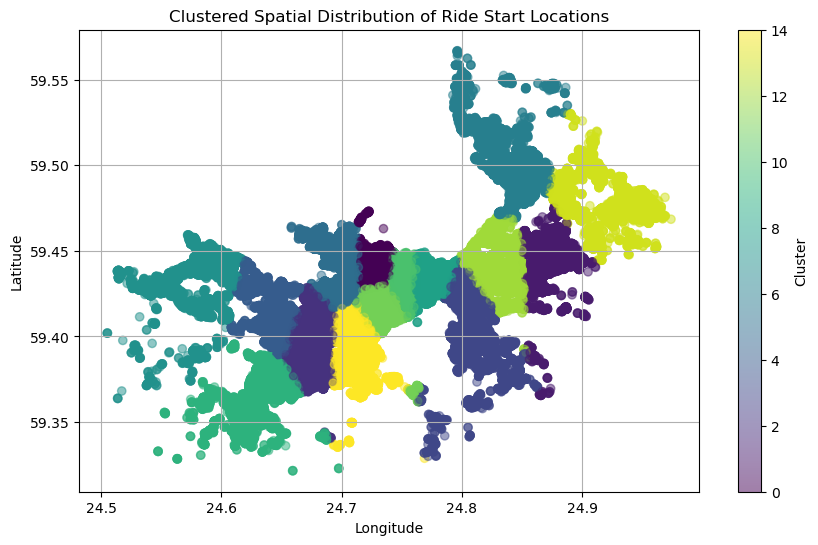

demand_cluster
0     1.829455
1     3.096521
2     2.394913
3     2.140435
4     2.550642
5     2.440714
6     4.159125
7     3.618694
8     2.156370
9     3.025961
10    1.847898
11    1.632061
12    3.283930
13    2.808361
14    2.826852
Name: ride_value, dtype: float64

In [15]:
from sklearn.cluster import KMeans

# Using KMeans to identify hotspots of high demand
# Prepare data for clustering
X = data[['start_lat', 'start_lng']]

# Determine optimal number of clusters using the Elbow method
# (For simplicity and time constraints, we'll choose a reasonable number of clusters)
kmeans = KMeans(n_clusters=15, random_state=0).fit(X)

# Assign cluster labels to original data
data['demand_cluster'] = kmeans.labels_

# Plotting the clusters to visualize high-demand locations
plt.figure(figsize=(10, 6))
plt.scatter(data['start_lng'], data['start_lat'], c=data['demand_cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustered Spatial Distribution of Ride Start Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Calculate average ride value by cluster
cluster_ride_value_avg = data.groupby('demand_cluster')['ride_value'].mean()

# Displaying average ride value by cluster
cluster_ride_value_avg


In [16]:
from geopy.distance import geodesic

# Defining a function to calculate displacement between start and end coordinates
def calculate_displacement(row):
    start_point = (row['start_lat'], row['start_lng'])
    end_point = (row['end_lat'], row['end_lng'])
    # Calculating the distance using geodesic distance (in kilometers)
    distance = geodesic(start_point, end_point).kilometers
    return distance

# Applying the function to each row in the DataFrame
data['displacement_km'] = data.apply(calculate_displacement, axis=1)
data.head()


from geopy.geocoders import Nominatim
import pandas as pd

# Initialize the geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

def get_district(lat, long):
    try:
        # Perform reverse geocoding to get the location details
        location = geolocator.reverse((lat, long), exactly_one=True, language='en')
        address = location.raw['address']
        
        # Extract the district or relevant location component
        district = address.get('suburb', None) or address.get('city_district', None) or address.get('county', None)
        return district
    except:
        # In case of any error, return None or a default value
        return None

# since above function will require too many api calls we will move to simplier approx solution
def get_district_name(lat, lon):
    # Define bounding boxes for each district
    districts = {
        'Haabersti': ((59.398, 24.635), (59.436, 24.718)),
        'City Centre': ((59.422, 24.713), (59.453, 24.777)),
        'Kristiine': ((59.411, 24.666), (59.437, 24.730)),
        'Lasnamäe': ((59.411, 24.790), (59.470, 24.889)),
        'Mustamäe': ((59.383, 24.641), (59.424, 24.716)),
        'Nõmme': ((59.357, 24.595), (59.403, 24.731)),
        'Pirita': ((59.436, 24.772), (59.501, 24.912)),
        'North Tallinn': ((59.429, 24.665), (59.458, 24.754)),
    }
    
    for district, ((sw_lat, sw_lon), (ne_lat, ne_lon)) in districts.items():
        if sw_lat <= lat <= ne_lat and sw_lon <= lon <= ne_lon:
            return district
    
    return "Unknown"

data['district'] = data.apply(lambda row: get_district_name(row['start_lat'], row['start_lng']), axis=1)
data['End_district'] = data.apply(lambda row: get_district_name(row['end_lat'], row['end_lng']), axis=1)
data.head()


def categorize_time(hour): 
    if 5 <= hour < 12:return 'Morning'
    elif 12 <= hour < 17 : return 'Afternoon'
    elif 17 <= hour < 21: return 'Evening'
    else: return 'Night'




# Extract  date,  hour,  day oy ueeh,  and month  froms tant_time
data['start_time']=pd.to_datetime(data['start_time'])
data['date'] = data['start_time'].dt.date
data['hour'] = data['start_time'].dt.hour
data['day_of_week'] = data['start_time'].dt.dayofweek # Mondoy=0, Sundoy=
data['month'] = data['start_time'].dt.month
data['time_of_day']=data['hour'].apply(categorize_time)


data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,value_cluster,cluster,demand_cluster,displacement_km,district,End_district,date,hour,day_of_week,month,time_of_day
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,9,0,2,14.205080,Haabersti,Unknown,2022-03-06,15,6,3,Afternoon
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,1,0,8,2.050095,City Centre,Unknown,2022-03-10,11,3,3,Morning
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,1,0,10,0.774715,City Centre,City Centre,2022-03-06,14,6,3,Afternoon
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,9,0,4,3.041401,Haabersti,Nõmme,2022-03-03,9,3,3,Morning
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,1,0,10,9.209442,City Centre,Pirita,2022-03-06,0,6,3,Night


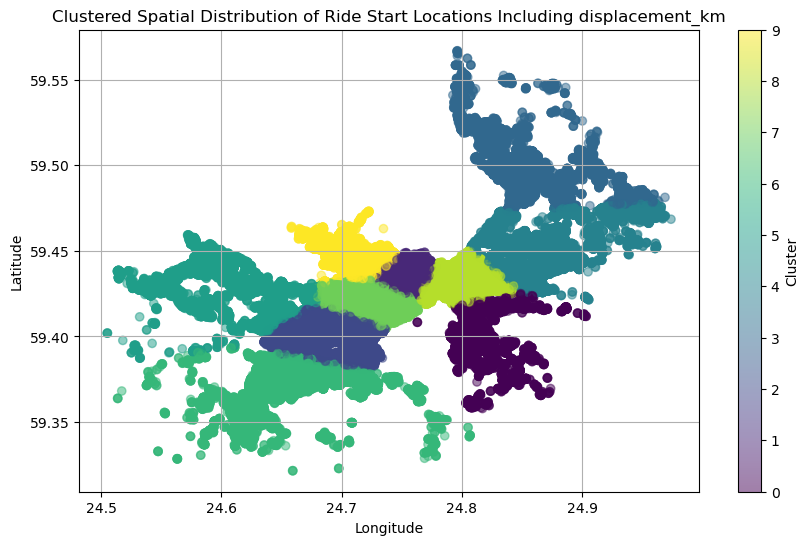

demand_cluster
0    2.842561
1    1.955593
2    2.427217
3    4.106693
4    3.159640
5    2.873858
6    3.218687
7    1.783656
8    2.203568
9    2.002368
Name: ride_value, dtype: float64


In [17]:

# Standardizing the features to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using the Elbow method
# For simplicity, we'll choose a reasonable number of clusters directly
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_scaled)

# Assign cluster labels to original data
data['demand_cluster'] = kmeans.labels_

# Plotting the clusters to visualize high-demand locations based on lat, lng
# Note: For plotting, we're using only lat and lng to visualize the distribution in 2D space
plt.figure(figsize=(10, 6))
plt.scatter(data['start_lng'], data['start_lat'], c=data['demand_cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustered Spatial Distribution of Ride Start Locations Including displacement_km')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Calculate average ride value by cluster
cluster_ride_value_avg = data.groupby('demand_cluster')['ride_value'].mean()

# Displaying average ride value by cluster
print(cluster_ride_value_avg)


In [18]:
# Perform groupby operation to get the count and sum of 'ride_value' based on 'date' and 'hour'
grouped_data = data.groupby(['date', 'hour','district']).agg(count=('ride_value', 'count'), sum=('ride_value', 'sum'))#.reset_index()

# Display the aggregated data
train_set=grouped_data.round().reset_index()
train_set.columns=['date' ,'hour' ,'district' ,'demand' ,'revenue']
train_set['lag_1'] = train_set['demand'].shift(1)
train_set['lag_2'] = train_set['demand'].shift(2)
train_set['lag_3'] = train_set['demand'].shift(3)
train_set['lag_4'] = train_set['demand'].shift(4)
train_set['rolling_mean'] = train_set['demand'].rolling(window=4).mean()
train_set.head()


,date,hour,district,demand,revenue,lag_1,lag_2,lag_3,lag_4,rolling_mean
0,2022-03-01,0,City Centre,382,2031.0,NaN,NaN,NaN,NaN,NaN
1,2022-03-01,0,Haabersti,64,117.0,382.0,NaN,NaN,NaN,NaN
2,2022-03-01,0,Kristiine,4,3.0,64.0,382.0,NaN,NaN,NaN
3,2022-03-01,0,Lasnamäe,33,52.0,4.0,64.0,382.0,NaN,120.75
4,2022-03-01,0,Mustamäe,20,31.0,33.0,4.0,64.0,382.0,30.25


In [19]:
# Re-importing necessary libraries after execution state reset
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import Lasso, Ridge


# Load the data (simulated for demonstration)
# In a real scenario, replace this with loading your actual time series data
df = train_set
# Splitting the time series into training and testing sets
split_point = int(len(df) * 0.8)
train, test = df['demand'][0:split_point], df['demand'][split_point:]

# Define and fit the ARIMA model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Calculate RMSE between the forecast and the actual test set
forecast_rmse = rmse(test, forecast)

print('arima',forecast_rmse)


df.fillna(0, inplace=True)

# Encoding categorical variables
encoder = LabelEncoder()
df['district_encoded'] = encoder.fit_transform(df['district'])

# Selecting features and target variable
X = df[['hour', 'district_encoded', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean']]
y = df['demand']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicting the demand on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"RMSE random forest: {rmse}")

# Assuming the DataFrame `df` has been preprocessed and split into X_train, X_test, y_train, y_test

# Initialize models
lasso_model = Lasso(alpha=0.1)
ridge_model = Ridge(alpha=0.1)

# Fit models
lasso_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

# Predict on test set
y_pred_lasso = lasso_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)

# Calculate RMSE
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)

print ("rmse lasso & ridge",rmse_lasso, rmse_ridge)

from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = mse_linear ** 0.5
print(f"Linear Regression RMSE: {rmse_linear}")

# XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, seed=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
print(f"XGBoost RMSE: {rmse_xgb}")


arima 157.1660031779213
RMSE random forest: 11.973084380675552
rmse lasso & ridge 1.4796553609734377 1.520625843157115
Linear Regression RMSE: 1.5206288556658722
XGBoost RMSE: 10.763065441321467


In [20]:
#!pip install hdbscan

In [21]:
# pridicting 

start_time_pred='02022-03-06 15:02:39.329452000'
start_lat_pred ='59.407910'
start_lng_pred ='24.689836'
get_district_name (start_lat_pred,start_lng_pred)

TypeError: '<=' not supported between instances of 'float' and 'str'

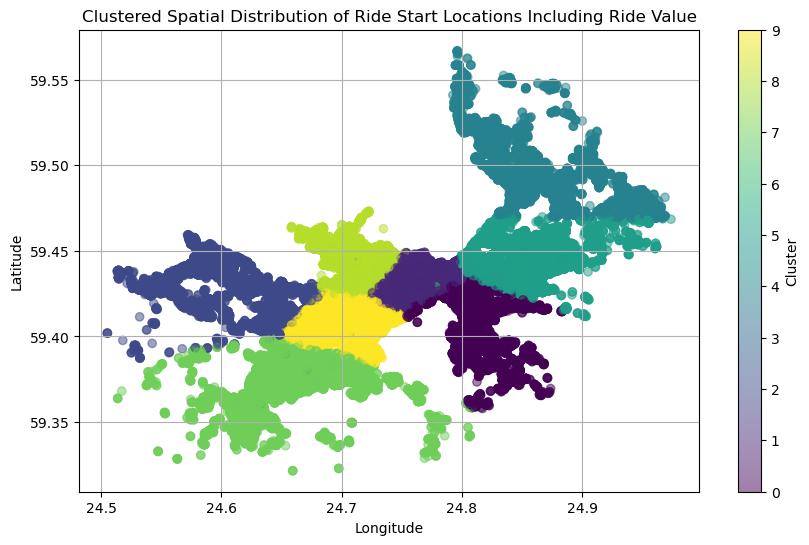

value_cluster
0       1.345698
1       1.010998
2       1.890881
3    1663.430869
4       2.626925
5       1.760904
6    2814.884862
7       2.127434
8       1.187721
9       1.317249
Name: ride_value, dtype: float64


In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' is your DataFrame

# Prepare data for clustering
# Adding 'ride_value' to the clustering features
X = data[['start_lat', 'start_lng', 'ride_value']]

# Standardizing the features to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using the Elbow method
# For simplicity, we'll choose a reasonable number of clusters directly
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_scaled)

# Assign cluster labels to original data
data['value_cluster'] = kmeans.labels_

# Plotting the clusters to visualize high-demand locations based on lat, lng
# Note: For plotting, we're using only lat and lng to visualize the distribution in 2D space
plt.figure(figsize=(10, 6))
plt.scatter(data['start_lng'], data['start_lat'], c=data['value_cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustered Spatial Distribution of Ride Start Locations Including Ride Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Calculate average ride value by cluster
cluster_ride_value_avg = data.groupby('value_cluster')['ride_value'].mean()

# Displaying average ride value by cluster
print(cluster_ride_value_avg)


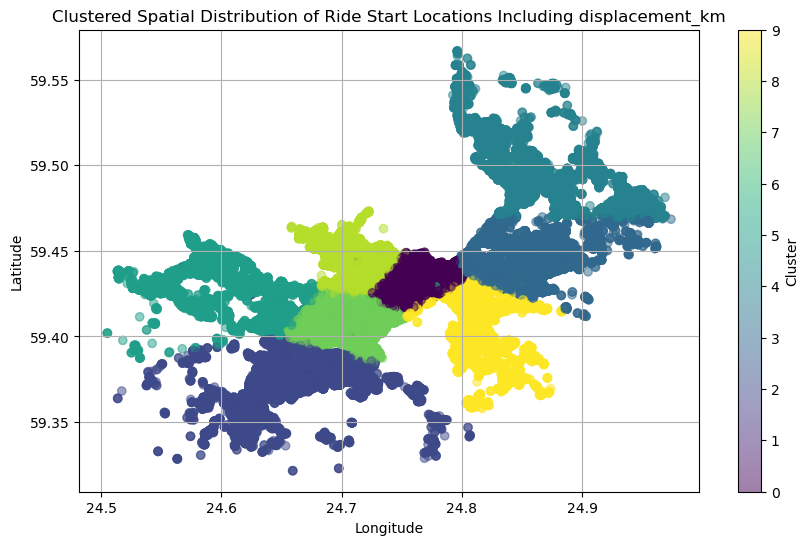

demand_cluster
0       1.011899
1    1670.080177
2       2.083223
3       1.759460
4       2.627361
5       1.888953
6    2825.535670
7       1.302935
8       1.187454
9       1.377162
Name: ride_value, dtype: float64


In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' is your DataFrame

# Prepare data for clustering
# Adding 'displacement_km' to the clustering features
X = data[['start_lat', 'start_lng', 'displacement_km']]

# Standardizing the features to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using the Elbow method
# For simplicity, we'll choose a reasonable number of clusters directly
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_scaled)

# Assign cluster labels to original data
data['demand_cluster'] = kmeans.labels_

# Plotting the clusters to visualize high-demand locations based on lat, lng
# Note: For plotting, we're using only lat and lng to visualize the distribution in 2D space
plt.figure(figsize=(10, 6))
plt.scatter(data['start_lng'], data['start_lat'], c=data['demand_cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustered Spatial Distribution of Ride Start Locations Including displacement_km')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Calculate average ride value by cluster
cluster_ride_value_avg = data.groupby('demand_cluster')['ride_value'].mean()

# Displaying average ride value by cluster
print(cluster_ride_value_avg)


In [24]:
#!pip install lightgbm

In [25]:
data

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,value_cluster,cluster,demand_cluster,displacement_km,district,End_district,date,hour,day_of_week,month,time_of_day
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.518250,9,0,7,14.205080,Haabersti,Unknown,2022-03-06,15,6,3,Afternoon
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.507500,1,0,0,2.050095,City Centre,Unknown,2022-03-10,11,3,3,Morning
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.190250,1,0,0,0.774715,City Centre,City Centre,2022-03-06,14,6,3,Afternoon
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.756000,9,0,7,3.041401,Haabersti,Nõmme,2022-03-03,9,3,3,Morning
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.271000,1,0,0,9.209442,City Centre,Pirita,2022-03-06,0,6,3,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627205,2022-03-16 06:19:39.281000,59.489132,24.870559,59.426810,24.672892,3.232051,4,61,4,13.185706,Pirita,Haabersti,2022-03-16,6,2,3,Morning
627206,2022-03-12 08:33:15.949213,59.428616,24.771929,59.439053,24.873362,1.436750,1,0,0,5.872664,City Centre,Lasnamäe,2022-03-12,8,5,3,Morning
627207,2022-03-16 06:20:33.475000,59.387015,24.705160,59.422822,24.697156,0.993888,7,0,2,4.014756,Mustamäe,Haabersti,2022-03-16,6,2,3,Morning
627208,2022-03-10 01:08:17.750884,59.441934,24.754971,59.437759,24.775483,0.307250,1,0,0,1.253364,City Centre,City Centre,2022-03-10,1,3,3,Night


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Feature and target selection
features = ['start_lat', 'start_lng', 'hour', 'day_of_week', 'month', 'displacement_km']
categorical_features = ['district', 'End_district', 'time_of_day']
X = data[features + categorical_features]
y = data['ride_value']  # or another column representing demand

# Preprocessing for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Create a modeling pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")


RMSE: 0.4194022940278707
